In this demo, we will perform scMTO cluster analysis using the large scale dataset [MRCA_BC](https://singlecell.broadinstitute.org/single_cell/study/SCP2559/mrca-scrna-seq-of-the-mouse-retina-bipolar-cell-subclass#study-summary).

## Import python package

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '64'
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import sys
sys.path.append('/home/zhenhaoyang/scMTO')

import torch
import scanpy as sc
import numpy as np
import random
from scMTO.preprocess import log1pnormscale
from scMTO.topic_function import graph_Laplacian_sparse
from scMTO.model_scale import scMTOSCAL, scGSTMSCAL
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = True
torch.set_num_threads(2)

In [2]:
seed = 666
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [3]:
argcuda = torch.cuda.is_available()
torch.cuda.set_device(3)
device = torch.device("cuda" if argcuda else "cpu")
print('device done')

device done


## Read data

Here, for the convenience of display, we directly load the preprocessed data.

In [ ]:
# adata = sc.read('data/MRCA_BC.h5ad')

In [4]:
# # Multi-View 1 (normalized, 1000HVGs)
# adata2 = adata.copy()
# adata.raw = adata.copy()
# sc.pp.filter_genes(adata, min_counts=10)
# sc.pp.filter_cells(adata, min_counts=100)
# sc.pp.normalize_total(adata, target_sum=1e3)
# adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=1000, subset=True)
# sc.pp.scale(adata)

# # Multi-View 1 (normalized, 500HVGs)
# sc.pp.filter_genes(adata2, min_counts=10)
# sc.pp.filter_cells(adata2, min_counts=100)
# sc.pp.normalize_total(adata2, target_sum=1e3)
# adata2.obs['size_factors'] = adata2.obs.n_counts / np.median(adata2.obs.n_counts)
# sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=500, subset=True)
# sc.pp.scale(adata2)

# # Multi-View 3 (sparse topic patterns, 1000HVGs) 
# highly_variable_genes = pd.Series(adata.var['highly_variable'].index)
# all_genes = pd.Series(adata.raw.var.index)
# indices = np.where(all_genes.isin(highly_variable_genes))[0]
# raw_data = np.ceil(adata.raw.X[:, indices].todense()).astype(int)

# y = pd.factorize(adata.obs['author_cell_type'])[0]
# count = [adata.X, adata2.X]
# n_clusters = int(max(y) - min(y) + 1)

In [3]:
# np.save('data/MRCA_BC_count.npy', adata.X)
# np.save('data/MRCA_BC_count2.npy', adata2.X)
# np.save('data/MRCA_BC_raw.npy', raw_data)
# np.save('data/MRCA_BC_label.npy', y)
# np.save('data/MRCA_BC_size_factors.npy', adata.obs.size_factors)

In [4]:
count1 = np.load('/home/zhenhaoyang/scGRDEC/data/MRCA_BC_count.npy') 
count2 = np.load('/home/zhenhaoyang/scGRDEC/data/MRCA_BC_count2.npy')
raw_data = np.load('/home/zhenhaoyang/scGRDEC/data/MRCA_BC_raw.npy')
size_factors = np.load('/home/zhenhaoyang/scGRDEC/data/MRCA_BC_size_factors.npy')
y = np.load('/home/zhenhaoyang/scGRDEC/data/MRCA_BC_label.npy')
n_clusters = int(max(y) - min(y) + 1)
n_raw_data = raw_data.shape[1]
print(f'n_clusters: {n_clusters}')

n_clusters: 15


## Initialize topic model 

In [5]:
# raw_norm = log1pnormscale(raw_data, 1024)
# L, S, D = graph_Laplacian_sparse(raw_norm, 10)
# scipy.sparse.save_npz('scale/L.npz', L)
# nmftm = scGSTMSCAL(20, lambda1=1.0, iteration=500)
# H, W = nmftm(raw_norm.T, L, S, D, 20)
# np.save('scale/W.npy', W.T)
# np.save('scale/H.npy', H.T)

In [6]:
import scipy
W = torch.Tensor(np.load('/home/zhenhaoyang/scGRDEC/scale/distWHL/W.npy')).to(device)
H = torch.Tensor(np.load('/home/zhenhaoyang/scGRDEC/scale/distWHL/H.npy')).to(device)
L = scipy.sparse.load_npz('/home/zhenhaoyang/scGRDEC/scale/distWHL/L.npz')
print('Topic model initialization')

Topic model initialization


## Initialize scMTO model

In [7]:
model = scMTOSCAL(n_clusters=n_clusters,
                  device=device,
                  x_raw=raw_data,
                  W=W, H=H, L=L).to(device)

print('Model initialization done')

Model initialization done


## Pre-training stage

In [ ]:
embeddings = model.pretrain(x=count1, 
                            x2=count2, 
                            raw_data=raw_data,  
                            size_factor=size_factors, 
                            pre_lr=1e-5, 
                            pre_epoch=50, 
                            batch_size=256)

Pre_training...
0: Pretrain Loss:0.402350
1: Pretrain Loss:0.364980


## Clustering stage

In [ ]:
fit_embeddings, pred, acc, nmi, ari = model.fit(x=count1, 
                                                x2=count2, 
                                                y=y, 
                                                raw_data=raw_data,
                                                size_factor=size_factors, 
                                                lr=1e-5, 
                                                train_epoch=20, 
                                                batch_size=256)

n_clusters:  15
k-means: acc: 0.8033459189414532, nmi: 0.8363125186119449, ari:0.7218250510670786
Clustering...
0: Total Loss 0.5339, ZINB Loss 0.1256, OT Loss 0.2333, KL Loss 0.2715
0 :acc 0.8984375000, nmi 0.8887734672, ari 0.9236685066

0: Total Loss 0.5253, ZINB Loss 0.1235, OT Loss 0.2414, KL Loss 0.2671
0 :acc 0.8984375000, nmi 0.8859527262, ari 0.9359990076

0: Total Loss 0.5233, ZINB Loss 0.1271, OT Loss 0.2282, KL Loss 0.2635
0 :acc 0.9179687500, nmi 0.9091824999, ari 0.9539001005

0: Total Loss 0.6309, ZINB Loss 0.1095, OT Loss 0.3202, KL Loss 0.3462
0 :acc 0.9218750000, nmi 0.8904157185, ari 0.8683879553

0: Total Loss 0.6222, ZINB Loss 0.1087, OT Loss 0.2998, KL Loss 0.3410
0 :acc 0.9257812500, nmi 0.8878879912, ari 0.8767565492

0: Total Loss 0.5479, ZINB Loss 0.1048, OT Loss 0.3180, KL Loss 0.2940
0 :acc 0.9414062500, nmi 0.9238285009, ari 0.9086582482

0: Total Loss 0.5661, ZINB Loss 0.1033, OT Loss 0.2971, KL Loss 0.3073
0 :acc 0.9335937500, nmi 0.9204890807, ari 0.9293

## Get the predicted label

In [11]:
z = model.autoencoder.z_layer([torch.Tensor(count1).to(device), 
                               torch.Tensor(count2).to(device)], 
                               torch.Tensor(raw_data).to(device))
q = 1.0 / (1.0 + torch.sum(torch.pow(z.unsqueeze(1) - model.cluster_layer, 2), 2) / 1.0)
q = q.pow((1.0 + 1.0) / 2.0)
q = (q.t() / torch.sum(q, 1)).t()

y_pred = q.data.cpu().detach().numpy().argmax(1)

## Evaluation

In [12]:
if y is not None:
    nmi = normalized_mutual_info_score(y, y_pred)
    ari = adjusted_rand_score(y, y_pred)
    print(f'NMI:{nmi:.4f}, ARI:{ari:.4f}')

NMI:0.9151, ARI:0.8456


## Visualize the cell embedding using UMAP

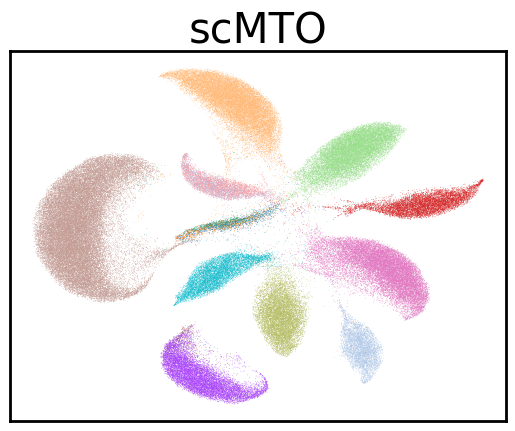

In [ ]:
import matplotlib.pyplot as plt 

fit_embeddings = fit_embeddings.cpu().detach().numpy()
adata_ref = sc.read('data/MRCA_BC.h5ad')
adata = sc.AnnData(fit_embeddings, obs=adata_ref.obs)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['author_cell_type'], show=False, legend_loc=None, title=None)
ax = plt.gca()
ax.set_title('scMTO', fontsize=30) 
ax.set_xlabel('')  
ax.set_ylabel('')  
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)